Pull data from Looker:

In [79]:
import pandas as pd
pd.set_option('display.max_colwidth', 200)
import numpy as np

In [171]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
def get_days_ordered(count):
    for k,v in count.items():
        if v==1:
            return k       

In [317]:
import json
import requests
import configparser


#Read config file with Looker API and Database connection information
config = configparser.ConfigParser(allow_no_value=True)
config.read('config')

#Very Basic Looker API class allowing us to access the data from a given Look ID
class lookerAPIClient:
    def __init__(self, api_host=None, api_client_id=None, api_secret=None, api_port='19999'):
        auth_request_payload = {'client_id': api_client_id, 'client_secret': api_secret}
        self.host = api_host
        self.uri_stub = '/api/3.0/'
        self.uri_full = ''.join([api_host, ':', api_port, self.uri_stub])
        response = requests.post(self.uri_full + 'login', params=auth_request_payload)
        authData = response.json()
        self.access_token = authData['access_token']
        self.auth_headers = {
                'Authorization' : 'token ' + self.access_token,
                }

    def post(self, call='', json_payload=None):
        response = requests.post(self.uri_full + call, headers=self.auth_headers, json=json_payload)
        return response.json()

    def get(self, call=''):
        response = requests.get(self.uri_full + call, headers=self.auth_headers)
        return json.loads(response.content) #response.json()

    def runLook(self, look, limit):
        optional_arguments = '?' + 'limit=' + str(limit)
        return self.get('/'.join(['looks',look,'run','json'])+optional_arguments)

In [392]:
#Initialize the Looker API Class with the data in our config file (which is stored in a neighboring file 'config')
x = lookerAPIClient(
        api_host      = config.get('api', 'api_host'), 
        api_client_id = config.get('api', 'api_client_id'), 
        api_secret    = config.get('api', 'api_secret'), 
        api_port      = config.get('api', 'api_port')
        )   

In [393]:
# Use the API to get data from the Look 
orders = x.runLook(look='1760', limit=100000)

In [394]:
df = pd.DataFrame(orders)

In [395]:
df.head()

orders.days_between_last_order_and_today  retained  \
0                                         1         1   
1                                         1         1   
2                                         1         1   
3                                         1         1   
4                                         1         1   

                                                                                                                                               user_order_facts.count  \
0  {'user_order_days.days_ordered_pc_gc_in_first_year': {'1': 1, '2': None, '3': None, '4': None, '5': None, '6': None, '7': None, '8': None, '9': None, '10': None}}   
1  {'user_order_days.days_ordered_pc_gc_in_first_year': {'1': 1, '2': None, '3': None, '4': None, '5': None, '6': None, '7': None, '8': None, '9': None, '10': None}}   
2  {'user_order_days.days_ordered_pc_gc_in_first_year': {'1': None, '2': 1, '3': None, '4': None, '5': None, '6': None, '7': None, '8': None, '9': None, '10': None}}   
3  {'user_order_days.days_ordered_pc_gc_in_first_year': {'1': None, '2': 1, '3': None, '4': None, '5': None, '6': None, '7': None, '8': None, '9': None, '10': None}}   
4  {'user_order_days.days_ordered_pc_gc_in_first_year': {'1': None, '2': 1, '3': None, '4': None, '5': None, '6': None, '7': None, '8': None, '9': None, '10': None}}   

   users.id  
0  39788541  
1  40253822  
2  39767430  
3  40003631  
4  40234650

In [396]:
df['days_ordered'] = df['user_order_facts.count'].apply(lambda x: get_days_ordered(x['user_order_days.days_ordered_pc_gc_in_first_year']))

In [397]:
df.drop('user_order_facts.count', axis=1, inplace=True)

In [398]:
df.drop('orders.days_between_last_order_and_today', axis=1, inplace=True)

In [399]:
df.head()

retained  users.id days_ordered
0         1  39788541            1
1         1  40253822            1
2         1  39767430            2
3         1  40003631            2
4         1  40234650            2

In [400]:
df['retained'] = df['retained'].astype(int)
df['days_ordered'] = df['days_ordered'].astype(int)

In [401]:
df_corr = df[['retained', 'days_ordered']]
df_corr.corr()

retained  days_ordered
retained      1.000000      0.488731
days_ordered  0.488731      1.000000

In [402]:
# this shows the correlation between retention and unique days ordered

In [403]:
ret_dummies = pd.get_dummies(df, columns=['days_ordered'])

In [404]:
ret_dummies.head()

retained  users.id  days_ordered_1  days_ordered_2  days_ordered_3  \
0         1  39788541               1               0               0   
1         1  40253822               1               0               0   
2         1  39767430               0               1               0   
3         1  40003631               0               1               0   
4         1  40234650               0               1               0   

   days_ordered_4  days_ordered_5  days_ordered_6  days_ordered_7  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   days_ordered_8  days_ordered_9  days_ordered_10  
0               0               0                0  
1               0               0                0  
2               0               0                0  
3               0               0                0  
4               0               0                0

In [405]:
correlated_cols = ['retained', 'days_ordered_1',
       'days_ordered_2', 'days_ordered_3', 'days_ordered_4', 'days_ordered_5',
       'days_ordered_6', 'days_ordered_7', 'days_ordered_8', 'days_ordered_9','days_ordered_10']

In [406]:
correl = ret_dummies[correlated_cols].corr()

In [407]:
# show correlation coefficients
# retention_corrs = pd.DataFrame(data=correl[1:]['retained']).rename(columns={'retained':'just because'})

In [408]:
# add other use cases to df
retention_corrs['thank you'] = correl[1:]['retained']

In [409]:
retention_corrs

just because  travelling      bulk  parenting  birthday  \
days_ordered_1      -0.445485   -0.375659 -0.440670  -0.383339 -0.439387   
days_ordered_2      -0.184204   -0.141211 -0.177617  -0.209504 -0.181897   
days_ordered_3       0.006198    0.013819 -0.023780  -0.043318  0.026506   
days_ordered_4       0.086130    0.088170  0.097530   0.036805  0.098188   
days_ordered_5       0.132029    0.105818  0.159655   0.097351  0.151790   
days_ordered_6       0.146260    0.117360  0.127094   0.123356  0.141488   
days_ordered_7       0.139918    0.111353  0.181316   0.153388  0.144806   
days_ordered_8       0.134753    0.112112  0.169253   0.136807  0.135019   
days_ordered_9       0.122757    0.100570  0.119028   0.137505  0.109417   
days_ordered_10      0.112496    0.087019  0.100252   0.120871  0.087607   

                  holiday  thank you  
days_ordered_1  -0.374659  -0.464036  
days_ordered_2  -0.114493  -0.172631  
days_ordered_3  -0.006421   0.006410  
days_ordered_4   0.058858   0.096361  
days_ordered_5   0.107018   0.144526  
days_ordered_6   0.144405   0.153845  
days_ordered_7   0.135768   0.147757  
days_ordered_8   0.134799   0.126017  
days_ordered_9   0.112679   0.116949  
days_ordered_10  0.088504   0.109980

In [413]:
retention_corrs.to_csv('retention_corrs_by_use_case.csv')

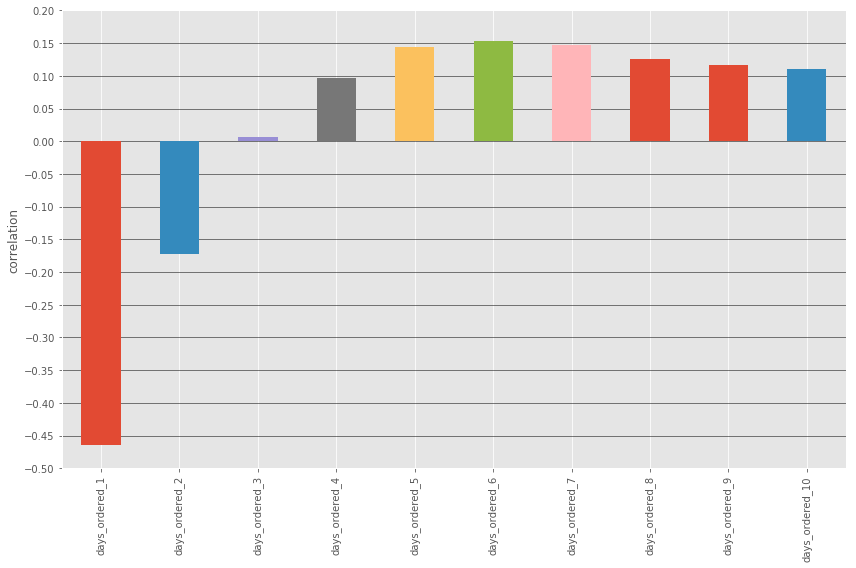

In [410]:
correl[1:].plot.bar(y='retained', legend=False, figsize=(12,8))
plt.ylim(-0.5, 0.2)
plt.yticks(np.arange(-0.5, 0.25, step=0.05))
plt.ylabel('correlation')
plt.grid(axis='y',linestyle='-', linewidth='0.5', color='black')
plt.tight_layout()
plt.savefig('retention_correl_thankyou.png', transparent=True)

In [228]:
#ret_dummies.to_csv('travelling_corr.csv')